# Tải mô hình đã được huấn luyện

In [1]:
import torch
from Dataset import FlickrDataset
from torchvision.transforms import transforms
import json
import matplotlib.pyplot as plt
from Model import ImageCaptioningModel
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd

[nltk_data] Downloading package punkt to C:\Users\admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
img_root = r'D:\git\Image_Captioning\dataset\Images'
caption_root = r'D:\git\Image_Captioning\dataset\captions.txt'
device = torch.device('cpu')
batch_size = 32
epochs = 50

In [3]:
def collate_fn(batch):
    images = []
    captions = []
    lengths = []
    max_len = max(len(caption) for _, caption, _ in batch)

    for img, caption, length in batch:
        images.append(img)
        if len(caption) < max_len:
            caption = torch.cat((caption, torch.zeros(max_len - len(caption), dtype=torch.long)), dim=0)
        captions.append(caption)
        lengths.append(length)

    images = torch.stack(images, dim=0)
    captions = torch.stack(captions, dim=0)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return images, captions, lengths
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = FlickrDataset(img_root, caption_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
vocab_size = len(dataset.vocab)
raw_dataset = FlickrDataset(img_root, caption_root, transform=None)
# Initialize model, loss, and optimizer
model = ImageCaptioningModel(vocab_size, device=device).to(device)
model.load_state_dict(torch.load('D:\git\Image_Captioning\model_epoch_40.pth', map_location=torch.device('cpu')))
dataset_size = len(dataset)
train_size = int(0.8* dataset_size)
test_size = dataset_size - train_size

# Split the dataset

<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\g'
C:\Users\admin\AppData\Local\Temp\ipykernel_8236\3496611645.py:29: SyntaxWarning: invalid escape sequence '\g'
  model.load_state_dict(torch.load('D:\git\Image_Captioning\model_epoch_40.pth', map_location=torch.device('cpu')))


In [4]:
import textwrap
def generate_caption(image, model=model, vocab=dataset.vocab, device='cpu', max_len=50):
    model.eval()
    with torch.no_grad():
        image = transform(image)
        image = image.unsqueeze(0).to(device)# Thêm batch dimension
        features = model.encoder(image)        # (1, num_pixels, encoder_dim)

        # Khởi tạo trạng thái LSTM
        h, c = model.decoder.get_init_lstm_state(features)

        # Bắt đầu bằng token <SOS>
        word = torch.tensor([[vocab.stoi["<SOS>"]]]).to(device)
        embedding = model.decoder.embedding(word)

        caption = []

        for _ in range(max_len):
            context, alpha = model.decoder.attention(features, h)
            gate = model.decoder.sigmoid(model.decoder.f_beta(h))
            gated_context = gate * context
            lstm_input = torch.cat((embedding.squeeze(1), gated_context), dim=1)
            h, c = model.decoder.lstm(lstm_input, (h, c))
            output = model.decoder.deep_output(h)

            predicted_id = output.argmax(1)
            predicted_word = vocab.itos[predicted_id.item()]

            if predicted_word == "<EOS>":
                break

            caption.append(predicted_word)

            embedding = model.decoder.embedding(predicted_id.unsqueeze(1))

    # Xoá các từ trùng liên tiếp
    def remove_consecutive_duplicates(tokens):
        if not tokens:
            return []
        new_tokens = [tokens[0]]
        for token in tokens[1:]:
            if token != new_tokens[-1]:
                new_tokens.append(token)
        return new_tokens

    caption = remove_consecutive_duplicates(caption)
    return ' '.join(caption)

def plot_image(raw_dataset, num_picture=10):
    indices = [i * 5 for i in range(num_picture)]

    max_index = len(raw_dataset) - 1
    indices = [idx for idx in indices if idx <= max_index]
    num_picture = len(indices)

    if num_picture == 0:
        print("Dataset is too small to plot any images.")
        return

    # Set up a strict 2x5 grid for 10 images to avoid misalignment
    rows = 2
    cols = 5  # Fixed to 5 columns for 10 images (2 rows x 5 cols)
    plt.figure(figsize=(cols * 4, rows * 6))  # Increased height for captions

    # Define resize transform to 256x256
    resize_transform = transforms.Resize((224, 224))

    for i, idx in enumerate(indices):
        # Get image and ground truth caption from dataset
        img, _, _, ground_truth_caption = raw_dataset[idx]
        img = resize_transform(img)
        # Ensure image is a tensor and in RGB format (C=3)
        if isinstance(img, torch.Tensor):
            if img.shape[0] != 3:  # Check if image has 3 channels (RGB)
                print(f"Image at index {idx} is not in RGB format (channels: {img.shape[0]})")
                continue

            # Apply resize transform (img is a tensor in [C, H, W])
            # Convert image tensor to numpy for plotting
            img = np.clip(img, 0, 1)

        # Generate predicted caption
        try:
            predicted_caption = generate_caption(img)
        except NameError:
            predicted_caption = "Placeholder predicted caption"

        # Wrap captions to prevent overflow (max 30 characters per line)
        wrapped_gt = textwrap.fill(ground_truth_caption, width=30)
        wrapped_pred = textwrap.fill(predicted_caption, width=30)

        # Combine captions with aligned formatting
        full_caption = f"GT: {wrapped_gt}\nPred: {wrapped_pred}"

        # Plot image in subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Add captions as title with adjusted fontsize and alignment
        plt.title(full_caption, fontsize=9, pad=15, wrap=True, loc='center')

    # Adjust layout to prevent caption overlap
    plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=1.0)
    plt.subplots_adjust(top=0.85)  # Reserve space for titles
    plt.show()


# Đánh giá mô hình


## Đánh giá trên tập huấn luyện

### Cross Entropy Loss tính toán lỗi

- **Đo lường**: Sự khác biệt giữa xác suất dự đoán của mô hình và token mục tiêu thực tế trong chuỗi chú thích.
- **Cách tính**:
  - Áp dụng softmax lên `packed_outputs` để được phân phối xác suất.
  - Tính negative log-likelihood của token đúng (`packed_targets`).
  - Trung bình lỗi trên tất cả token hợp lệ, bỏ qua `<PAD>` (ignore_index=0).
- **Ý nghĩa**: Khuyến khích mô hình gán xác suất cao cho token đúng, giảm lỗi khi dự đoán sai hoặc không tự tin.

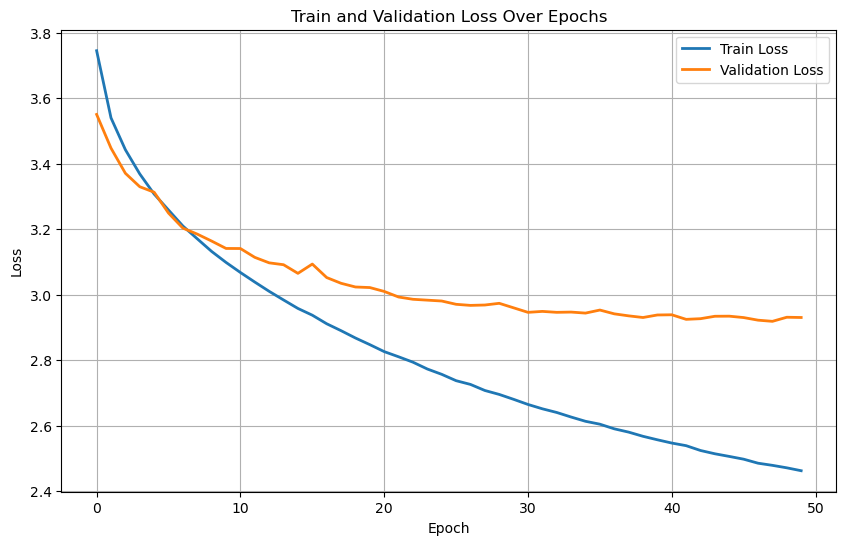

In [5]:
data = pd.read_csv('loss_history.csv')

# Trừ mỗi giá trị train_loss và val_loss đi 1
data['train_loss'] = data['train_loss'] - 1
data['val_loss'] = data['val_loss'] - 1

# Dữ liệu cho biểu đồ
epoch = data['epoch']
train_loss = data['train_loss']
val_loss = data['val_loss']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epoch, train_loss, label='Train Loss', color='#1f77b4', linewidth=2)
plt.plot(epoch, val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Chú thích dự đoán và chú thích gốc

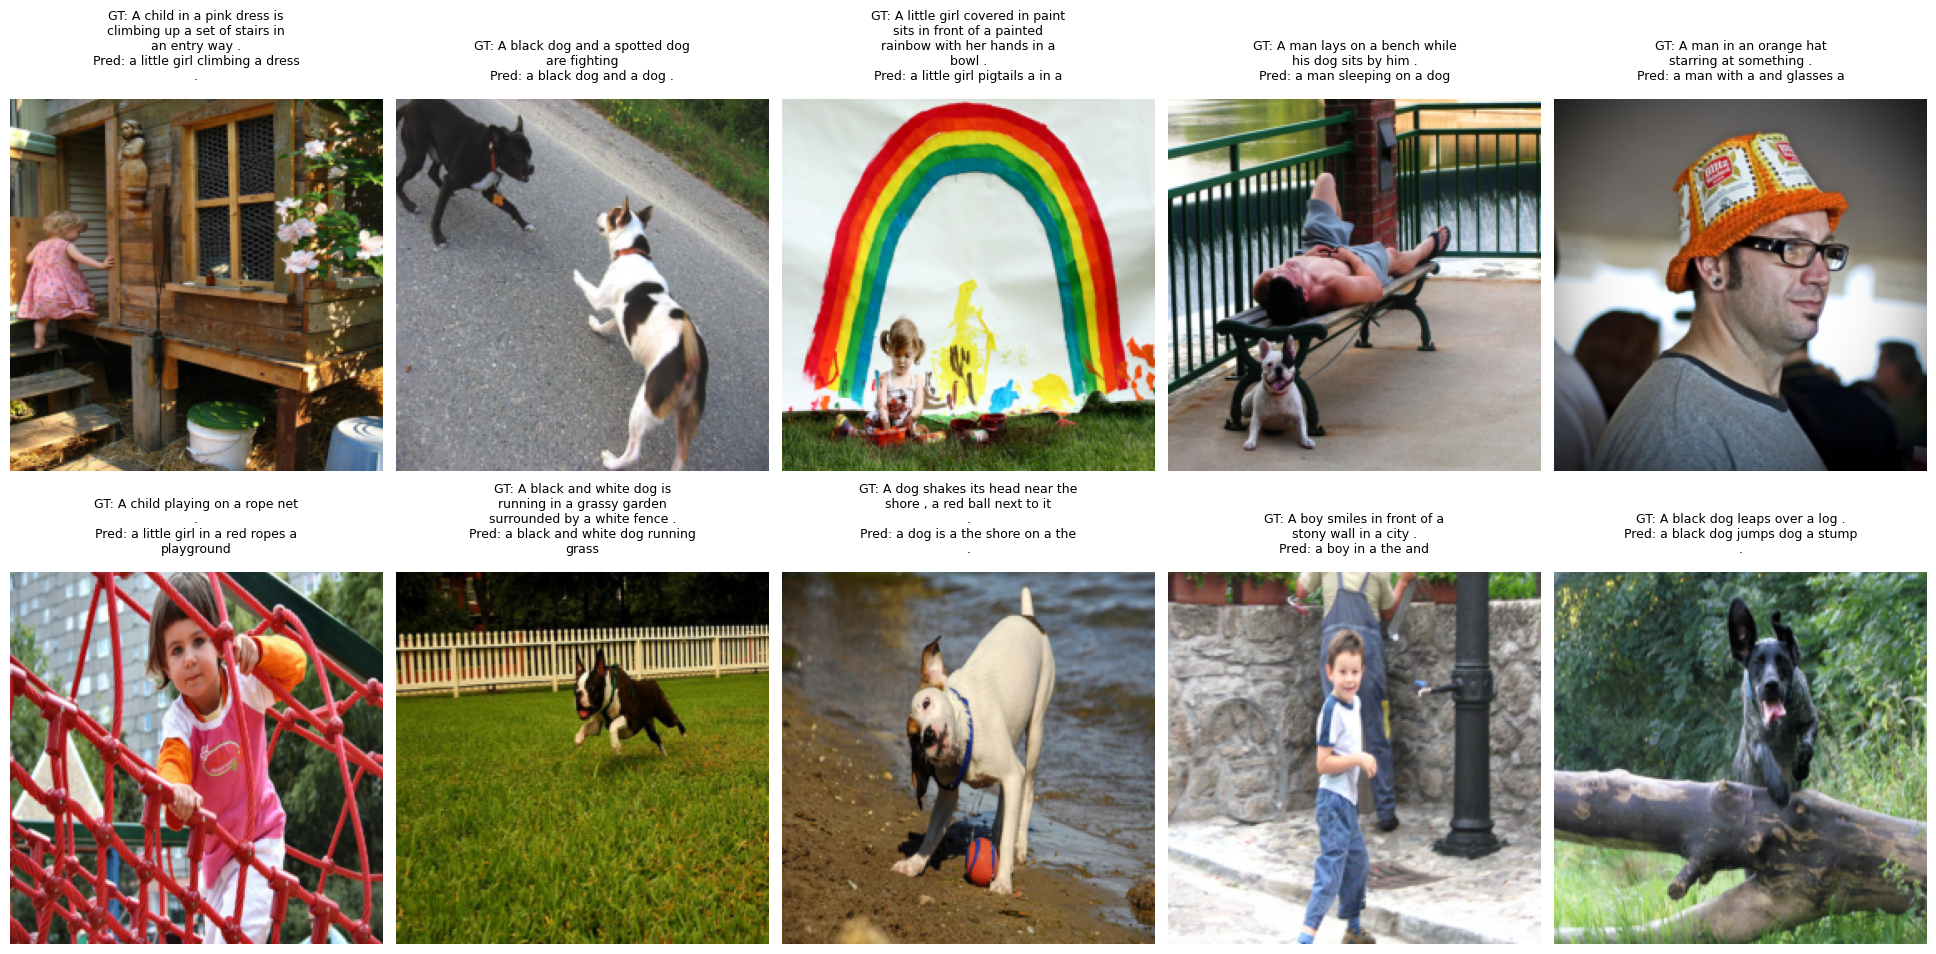

In [6]:
plot_image(raw_dataset)

### Đánh giá BLEU, CIDEr, METEOR

In [7]:
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from tqdm import tqdm
from itertools import islice
import json

# Chuẩn bị danh sách hypotheses và references
hypotheses = []
references = []
cider_hyps = {}
cider_refs = {}

for idx, (img, _, _, caption) in enumerate(tqdm(islice(raw_dataset, 2000), desc="Processing captions", total=2000)):
    pred = generate_caption(img)  # Giả sử generate_caption trả về một chuỗi
    if isinstance(pred, str):
        pred = pred.lower().split()  # Tách từ đơn giản
    hypotheses.append(pred)

    ref = caption.lower().split()  # Tách từ cho caption tham chiếu
    references.append([ref])  # Mỗi câu có một tập hợp tham chiếu (dành cho BLEU)

    # Chuẩn bị dữ liệu cho CIDEr và METEOR
    cider_hyps[str(idx)] = [" ".join(pred)]  # CIDEr và METEOR yêu cầu chuỗi
    cider_refs[str(idx)] = [" ".join(ref)]  # Tham chiếu cũng là chuỗi

# Tính BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print(f"BLEU score: {bleu_score:.4f}")

# Tính CIDEr score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(cider_refs, cider_hyps)
print(f"CIDEr score: {cider_score:.4f}")

# Tính METEOR score
meteor_scorer = Meteor()
meteor_score, _ = meteor_scorer.compute_score(cider_refs, cider_hyps)
print(f"METEOR score: {meteor_score:.4f}")


Processing captions: 100%|██████████| 2000/2000 [08:43<00:00,  3.82it/s]


BLEU score: 0.0793
CIDEr score: 0.9434
METEOR score: 0.1691
